<a href="https://colab.research.google.com/github/raheelsiddiqi2013/fruit-grading/blob/main/LocalSindhiGradingFifthNotebook_MobileNetV2_Frozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading of Local Sindhi Guava
This notebook is written and executed by **Raheel Siddiqi, PhD**. Fruit grading of **Local Sindhi** guava is performed. It is a multi-class classification problem with three classes: "Green", "Mature Green", and "Ripe". The dataset consists of 711 images with a train-validation-test split of 70-15-15. The pre-trained VGG16 model is used for feature extraction, while a densely connected network is used for final classification. A test set classification accuracy of **97.16%** has been achieved.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## Connecting to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi"

Test  Train  Validation


## Importing Relevant Libraries

In [4]:
# Import
import numpy as np
from PIL import Image
import os

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Pre-Trained Model
The convolutional base of the pre-trained **MobileNetV2** model will act as the feature extractor. All layers of the feature extractor are frozen.

In [5]:
mobile_net_v2 = MobileNetV2(weights='imagenet', include_top = False, pooling = "avg")
for layer in mobile_net_v2.layers:
            layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


## Loading Data

In [6]:
# Create Generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


# Create Data Loaders
train_loader = train_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Train",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

validation_loader= validation_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Validation",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

test_loader = test_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test",
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True
)

Found 498 images belonging to 3 classes.
Found 107 images belonging to 3 classes.
Found 106 images belonging to 3 classes.


## Sample Dataset Images

In [7]:
def plotImages(images_arr,label_arr,rev_look_up):
  fig,axes=plt.subplots(3,3)
  axes=axes.flatten()
  for img,label,ax in zip(images_arr,label_arr,axes):
    ax.imshow(img)
    ax.set_title(rev_look_up[np.argmax(label)])
    ax.axis('off')
  plt.tight_layout()
  plt.show()

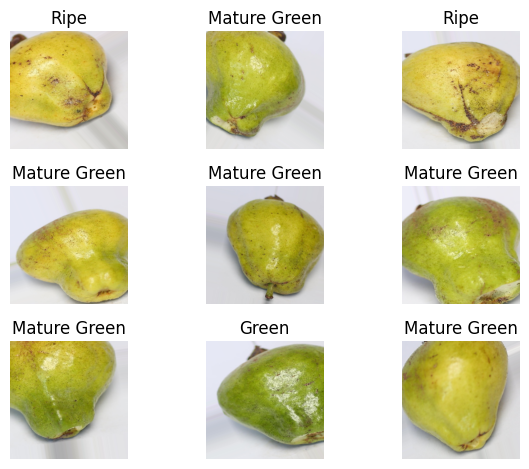

In [8]:
imgs, labels = train_loader[0]
reverse_lookup={val:key for key, val in dict(train_loader.class_indices).items()}
plotImages(imgs,labels,reverse_lookup)

In [9]:
print(imgs.shape)

(32, 224, 224, 3)


## Dataset Classes

In [10]:
train_loader.class_indices

{'Green': 0, 'Mature Green': 1, 'Ripe': 2}

## Hyperparameter Settings and Model Compilation

In [11]:
from keras.callbacks import ModelCheckpoint
import keras

optimizer = keras.optimizers.Adam(lr=0.0001)
model = Sequential()
model.add(mobile_net_v2)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])
model.summary()

filepath="best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True)
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Model Training

In [12]:
import math

model_train_history = model.fit_generator(
    generator = train_loader,
    steps_per_epoch = math.ceil(498//32),
    epochs = 100,
    callbacks=callbacks_list,
    validation_data = validation_loader,
    validation_steps = math.ceil(107//32)
)

<ipython-input-12-6e726d79eb7f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_train_history = model.fit_generator(


Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6578 - categorical_accuracy: 0.7210

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 128s 8s/step - loss: 0.6578 - categorical_accuracy: 0.7210 - val_loss: 0.4256 - val_categorical_accuracy: 0.8021
Epoch 2/100
15/15 [==============================] - 11s 772ms/step - loss: 0.3403 - categorical_accuracy: 0.8841 - val_loss: 0.2825 - val_categorical_accuracy: 0.9062
Epoch 3/100
15/15 [==============================] - 12s 780ms/step - loss: 0.3045 - categorical_accuracy: 0.8604 - val_loss: 0.2881 - val_categorical_accuracy: 0.8958
Epoch 4/100
15/15 [==============================] - 12s 782ms/step - loss: 0.2400 - categorical_accuracy: 0.9120 - val_loss: 0.2083 - val_categorical_accuracy: 0.9271
Epoch 5/100
15/15 [==============================] - 13s 858ms/step - loss: 0.2039 - categorical_accuracy: 0.9335 - val_loss: 0.1748 - val_categorical_accuracy: 0.9271
Epoch 6/100
15/15 [==============================] - 11s 762ms/step - loss: 0.2404 - categorical_accuracy: 0.8970 - val_loss: 0.2688 - val_categorical_accuracy: 0.9062
Epoch 

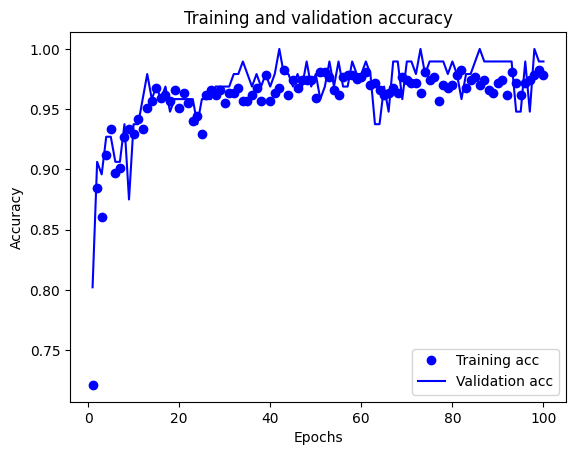

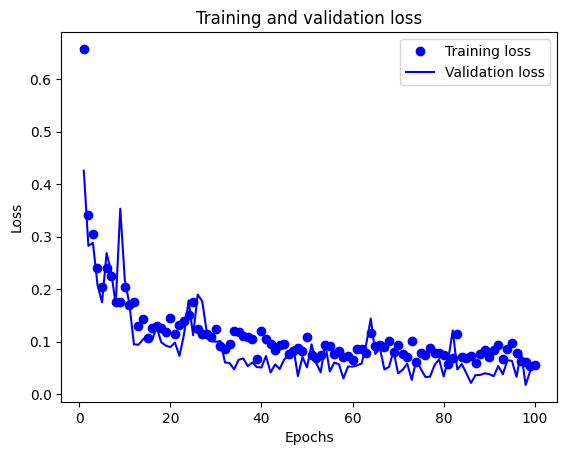

In [13]:
acc=model_train_history.history['categorical_accuracy']
val_acc=model_train_history.history['val_categorical_accuracy']
loss=model_train_history.history['loss']
val_loss=model_train_history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Testing and Confusion Matrix

First I prepare the test data.

In [14]:
# Preparing test data
import glob
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import cv2

green_cases_dir = Path('/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Green')
mature_green_cases_dir = Path(r'/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Mature Green')
ripe_cases_dir= Path('/content/drive/MyDrive/MyResearch/FruitGrading/LocalSindhi/Test/Ripe')

green_cases = green_cases_dir.glob('*.jpg')
mature_green_cases = mature_green_cases_dir.glob('*.jpg')
ripe_cases = ripe_cases_dir.glob('*.jpg')

image_width=224
image_height=224

test_data = []
test_labels = []

for img in green_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)

for img in mature_green_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)

for img in ripe_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (image_width,image_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [2]
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_labels_one_hot_encoding=to_categorical(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (106, 224, 224, 3)
Total number of labels: (106, 1)


In [15]:
from keras.models import load_model
best_model = load_model('best_model.h5')

The following is the model accuracy on the test set:

In [16]:
# Evaluation on test dataset

test_loss, test_score = best_model.evaluate(test_data, test_labels_one_hot_encoding, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

4/4 [==============================] - 2s 285ms/step - loss: 0.0794 - categorical_accuracy: 0.9717
Loss on test set:  0.07936114072799683
Accuracy on test set:  0.9716981053352356


Now I get all the model predictions.

In [17]:
# Get predictions
preds = best_model.predict(test_data, batch_size=32)
preds=np.around(preds)
orig_test_labels=test_labels
predicted_labels=np.argmax(preds,axis=1)
predicted_labels=np.reshape(predicted_labels,(106,1))

4/4 [==============================] - 1s 35ms/step


The following is the confusion matrix for the model:

<Figure size 640x480 with 0 Axes>

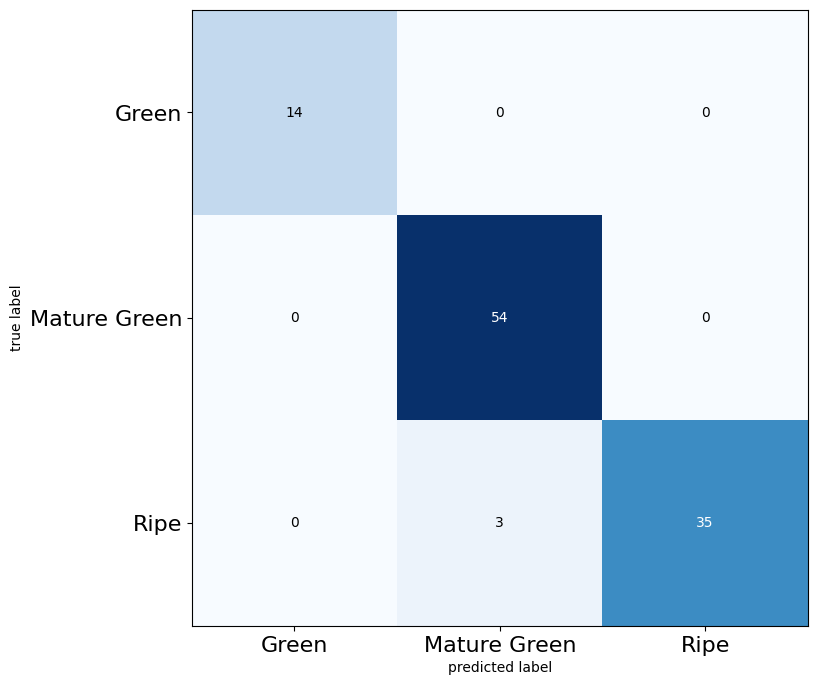

In [18]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.yticks(range(3), ['Green','Mature Green','Ripe'], fontsize=16)
plt.show()